# Simple CNN implemented using Keras (mnist dataset)

In [1]:
# importing necessary packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# Load a sample dataset (MNIST for simplicity)
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [2]:
# Normalize and reshape data
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, axis=-1) # Add channel dimension
x_test = np.expand_dims(x_test, axis=-1)

In [3]:
# Define a simple CNN model
model = keras.Sequential([
layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
layers.MaxPooling2D((2, 2)),
layers.Conv2D(64, (3, 3), activation="relu"),
layers.MaxPooling2D((2, 2)),
layers.Flatten(),
layers.Dense(128, activation="relu"),
layers.Dense(10, activation="softmax") # 10 classes for MNIST digits
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
# Compile the model
model.compile(optimizer="adam",

loss="sparse_categorical_crossentropy",
metrics=["accuracy"])

In [5]:
# Train the model
model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 58s 30ms/step - accuracy: 0.9074 - loss: 0.3062 - val_accuracy: 0.9870 - val_loss: 0.0405
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 79s 28ms/step - accuracy: 0.9860 - loss: 0.0443 - val_accuracy: 0.9889 - val_loss: 0.0355
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 55s 29ms/step - accuracy: 0.9908 - loss: 0.0281 - val_accuracy: 0.9856 - val_loss: 0.0420
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 78s 27ms/step - accuracy: 0.9931 - loss: 0.0208 - val_accuracy: 0.9902 - val_loss: 0.0264
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 83s 28ms/step - accuracy: 0.9954 - loss: 0.0147 - val_accuracy: 0.9903 - val_loss: 0.0292


In [7]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9864 - loss: 0.0372
Test accuracy: 0.9903


In [8]:
# Make predictions
predictions = model.predict(x_test[:5])
predicted_labels = np.argmax(predictions, axis=1)
print("Predicted labels:", predicted_labels)
print("Actual labels: ", y_test[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Predicted labels: [7 2 1 0 4]
Actual labels:  [7 2 1 0 4]


# 1. Data Understanding and Visualization

## 1a. Load, List, and Visualize Images from Directories

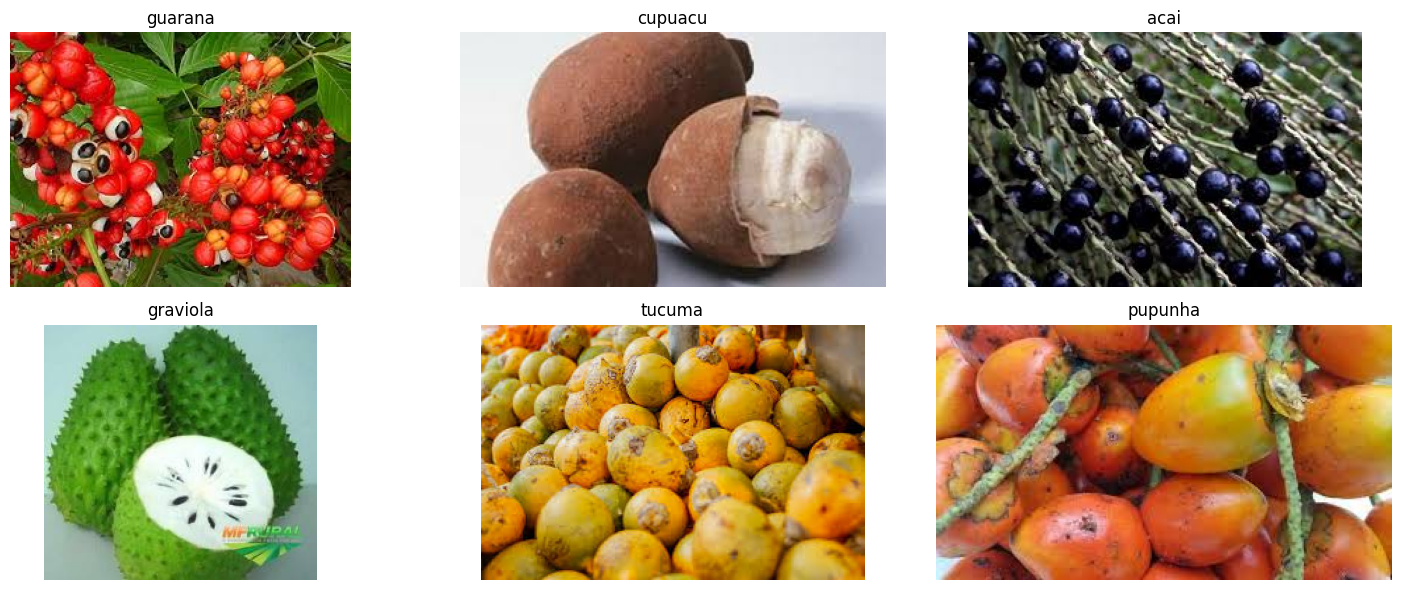

In [9]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Set the directory containing the training images (each subdirectory is a class)
train_dir = "/content/drive/MyDrive/FruitinAmazon/FruitinAmazon/train"  # update this path

# Get list of class directories
class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Prepare list for images and titles
images = []
titles = []

# Randomly select one image from each class
for cls in class_dirs:
    cls_dir = os.path.join(train_dir, cls)
    image_files = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if image_files:  # if the class folder is not empty
        selected_image = random.choice(image_files)
        image_path = os.path.join(cls_dir, selected_image)
        try:
            img = Image.open(image_path)
            images.append(img)
            titles.append(cls)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")

# Display images in a grid with two rows
num_images = len(images)
cols = (num_images + 1) // 2  # number of columns
plt.figure(figsize=(15, 6))
for i, img in enumerate(images):
    plt.subplot(2, cols, i+1)
    plt.imshow(img)
    plt.title(titles[i])
    plt.axis("off")
plt.tight_layout()
plt.show()

## 1b. Check for Corrupted Images

In [10]:
import os
from PIL import Image

corrupted_images = []

for cls in class_dirs:
    cls_dir = os.path.join(train_dir, cls)
    for file in os.listdir(cls_dir):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(cls_dir, file)
            try:
                # Try to open the image
                with Image.open(image_path) as img:
                    img.verify()  # Verify that it is, in fact, an image
            except (IOError, SyntaxError) as e:
                corrupted_images.append(image_path)
                os.remove(image_path)
                print(f"Removed corrupted image: {image_path}")

if not corrupted_images:
    print("No corrupted images found.")

No corrupted images found.


# 2. Loading and Preprocessing Image Data Using Keras

In [11]:
import tensorflow as tf

# Parameters
img_height = 128
img_width = 128
batch_size = 32
validation_split = 0.2
seed = 123

# Create a normalization layer
rescale = tf.keras.layers.Rescaling(1./255)

# Create training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=seed
)

# Normalize training data
train_ds = train_ds.map(lambda x, y: (rescale(x), y))

# Create validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=seed
)

# Normalize validation data
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


# 3. Implementing the CNN Model

In [12]:
from tensorflow.keras import layers, models

raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=seed
)

# Get the number of classes before mapping
num_classes = len(raw_train_ds.class_names)

# Then apply the normalization
train_ds = raw_train_ds.map(lambda x, y: (rescale(x), y))

model = models.Sequential([
    # Convolutional Layer 1
    layers.Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(img_height, img_width, 3)),
    # Pooling Layer 1
    layers.MaxPooling2D((2, 2), strides=2),

    # Convolutional Layer 2
    layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
    # Pooling Layer 2
    layers.MaxPooling2D((2, 2), strides=2),

    # Flatten Layer
    layers.Flatten(),

    # Fully Connected Layers
    layers.Dense(64, activation="relu"),
    layers.Dense(128, activation="relu"),

    # Output Layer
    layers.Dense(num_classes, activation="softmax")
])

model.summary()

Found 90 files belonging to 6 classes.
Using 72 files for training.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

# 4. Model Compilation

In [13]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# 5. Model Training

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Callbacks
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    batch_size=16,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.1748 - loss: 1.8665
Epoch 1: val_accuracy improved from -inf to 0.05556, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 752ms/step - accuracy: 0.1762 - loss: 1.8711 - val_accuracy: 0.0556 - val_loss: 1.7009
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.2946 - loss: 1.6947
Epoch 2: val_accuracy improved from 0.05556 to 0.77778, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 508ms/step - accuracy: 0.2973 - loss: 1.6942 - val_accuracy: 0.7778 - val_loss: 1.3676
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.5758 - loss: 1.4725
Epoch 3: val_accuracy did not improve from 0.77778
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 594ms/step - accuracy: 0.5707 - loss: 1.4642 - val_accuracy: 0.6667 - val_loss: 1.2496
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.4427 - loss: 1.2763
Epoch 4: val_accuracy improved from 0.77778 to 0.94444, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 752ms/step - accuracy: 0.4570 - loss: 1.2604 - val_accuracy: 0.9444 - val_loss: 0.8303
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7552 - loss: 0.9098
Epoch 5: val_accuracy did not improve from 0.94444
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 438ms/step - accuracy: 0.7539 - loss: 0.9098 - val_accuracy: 0.6667 - val_loss: 1.2421
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.8102 - loss: 0.7557
Epoch 6: val_accuracy did not improve from 0.94444
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 421ms/step - accuracy: 0.8090 - loss: 0.7488 - val_accuracy: 0.8333 - val_loss: 0.6222
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.9091 - loss: 0.4583
Epoch 7: val_accuracy did not improve from 0.94444
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 416ms/step - accuracy: 0.9145 - loss: 0.4530 - val_accuracy: 0.7778 - val_loss: 0.8188
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9601 - loss: 0.3492
Epoch 8: val_accuracy did not improve from 0.94

# 6. Model Evaluation

In [15]:
# Load test dataset (modify 'test_dir' accordingly)
test_dir = "/content/drive/MyDrive/FruitinAmazon/FruitinAmazon/test"  # update this path
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 66s 66s/step - accuracy: 0.6667 - loss: 0.9484
Test Loss: 0.9484
Test Accuracy: 0.6667


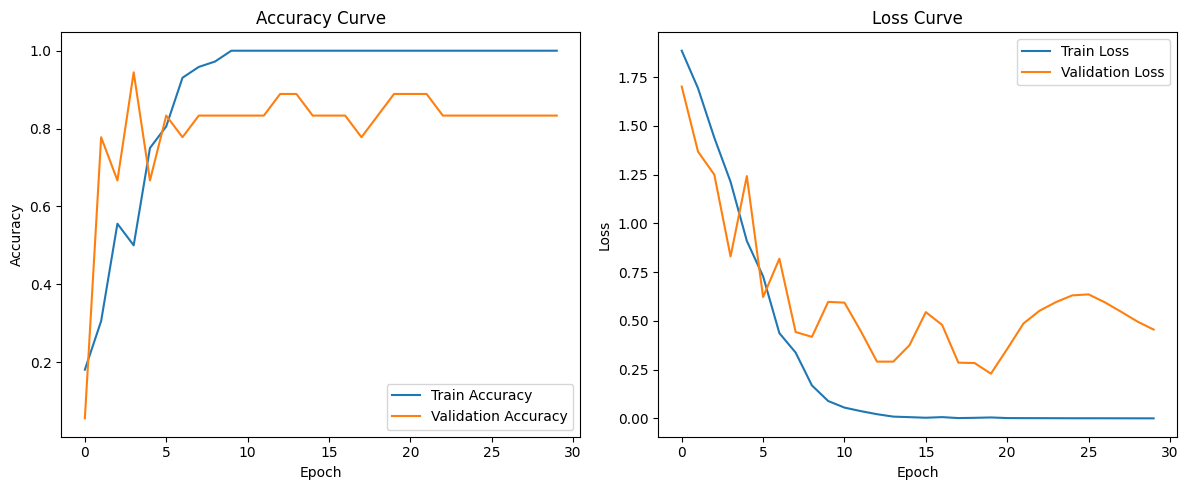

In [16]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

# Plot loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.tight_layout()
plt.show()

# 7. Saving and Loading the Model

In [17]:
# Save the model
model.save("cnn_model.h5")

# Later, load the model
loaded_model = tf.keras.models.load_model("cnn_model.h5")

# Re-evaluate the loaded model on the test set
loaded_test_loss, loaded_test_acc = loaded_model.evaluate(test_ds)
print(f"Loaded Model Test Accuracy: {loaded_test_acc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step - accuracy: 0.6667 - loss: 0.9484
Loaded Model Test Accuracy: 0.6667


# 8. Predictions and Classification Report

In [18]:
import numpy as np
from sklearn.metrics import classification_report

raw_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

target_names = raw_test_ds.class_names

test_ds = raw_test_ds.map(lambda x, y: (rescale(x), y))

# Get true labels and predicted labels from test_ds
y_true = np.concatenate([y for x, y in test_ds], axis=0)
predictions = loaded_model.predict(test_ds)
y_pred = np.argmax(predictions, axis=1)

# Print classification report
print(classification_report(y_true, y_pred, target_names=target_names))

Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
              precision    recall  f1-score   support

        acai       0.67      0.80      0.73         5
     cupuacu       0.50      0.80      0.62         5
    graviola       0.83      1.00      0.91         5
     guarana       1.00      0.20      0.33         5
     pupunha       0.62      1.00      0.77         5
      tucuma       1.00      0.20      0.33         5

    accuracy                           0.67        30
   macro avg       0.77      0.67      0.61        30
weighted avg       0.77      0.67      0.61        30

